# Setting variables

In [1]:
workDir = '/home/chantal/Chazy/Chazy_SIP/data/'
figDir = '/home/chantal/Chazy/Chazy_SIP/data/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqFile = 'SIP-core'


# l2fc params
l2fc_threshold = 0.25
BD_windows = ['1.70-1.73', '1.72-1.75', '1.74-1.77']
padj_cutoff = 0.1

# misc
nprocs = 20

# Init

In [2]:
import os
%load_ext rpy2.ipython
#%load_ext pushnote

In [3]:
%%R
library(vegan)
library(phyloseq)
library(grid); library(gridExtra)
library(tidyr)
library(plyr); library(dplyr)
library(ggplot2)


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: permute

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattice

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: This is vegan 2.3-5

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  res = super(Function, self).__call__(*new_args, 

In [4]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
    
if not os.path.isdir(figDir):
    os.makedirs(figDir)    

In [5]:
%%R -i l2fc_threshold -i BD_windows -i nprocs -i padj_cutoff

cat('Params loaded in R\n')

Params loaded in R


# Loading phyloseq

In [6]:
%%R -i physeqDir -i physeqFile 

F = file.path(physeqDir, physeqFile)
physeq = readRDS(F)
physeq.m = physeq %>% sample_data
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 21115 taxa and 608 samples ]
sample_data() Sample Data:       [ 608 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 21115 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 21115 tips and 21114 internal nodes ]


## Read in LFC df

In [7]:
%%R
df.l2fc.f = read.table('/home/chantal/Chazy/Chazy_SIP/data/l2fc_sparse-maxRejH.txt', sep = '\t', header = TRUE)
df.l2fc.f$Substrate = df.l2fc.f$Treatment
df.l2fc.f$ls = as.character(paste(df.l2fc.f$Treatment, df.l2fc.f$Land_Management, sep = "-"))

In [8]:
%%R
resp_num = filter(df.l2fc.f, padj <=0.10)
print(length(resp_num$OTU))
print(length(unique(resp_num$OTU)))

[1] 5096
[1] 1913


In [9]:
%%R
df.l2fc.f %>% filter(padj <=0.10) %>% group_by(ls) %>% summarise(resp = length(unique(OTU)))

Source: local data frame [4 x 2]

       ls  resp
    (chr) (int)
1 13C-NTH  1062
2 13C-PTH   935
3 13X-NTH   582
4 13X-PTH   604


In [10]:
%%R
df.l2fc.f %>% filter(padj <=0.10) %>% group_by(ls, Day) %>% summarise(resp = length(unique(OTU)))

Source: local data frame [16 x 3]
Groups: ls [?]

        ls   Day  resp
     (chr) (int) (int)
1  13C-NTH     3    17
2  13C-NTH     7   345
3  13C-NTH    14   545
4  13C-NTH    30   728
5  13C-PTH     3   185
6  13C-PTH     7   128
7  13C-PTH    14   412
8  13C-PTH    30   623
9  13X-NTH     1   127
10 13X-NTH     3   295
11 13X-NTH     7   282
12 13X-NTH    14   356
13 13X-PTH     1   161
14 13X-PTH     3   293
15 13X-PTH     7   296
16 13X-PTH    14   303


In [11]:
%%R
N.X = filter(df.l2fc.f, ls == '13X-NTH', padj <=0.10)
P.X = filter(df.l2fc.f, ls == '13X-PTH', padj <=0.10)
N.C = filter(df.l2fc.f, ls == '13C-NTH', padj <=0.10)
P.C = filter(df.l2fc.f, ls == '13C-PTH', padj <=0.10)

In [12]:
%%R
print(length(intersect(N.X$OTU, P.X$OTU)))
print(length(intersect(N.X$OTU, N.C$OTU)))
print(length(intersect(N.X$OTU, P.C$OTU)))
print(length(intersect(P.X$OTU, N.C$OTU)))
print(length(intersect(P.X$OTU, P.C$OTU)))
print(length(intersect(N.C$OTU, P.C$OTU)))

[1] 352
[1] 263
[1] 224
[1] 269
[1] 281
[1] 440


In [13]:
%%R ## OTUs intersecting across entire timepoints
length(Reduce(intersect, list(N.X$OTU, P.X$OTU, N.C$OTU, P.C$OTU)))

NULL


In [14]:
%%R
#Looking at non-overlap communities b/t NT Xyl, PT Xyl and NT Cell, PT Cell
N.X.no = filter(N.X, !(OTU %in% intersect(N.X$OTU, P.X$OTU)))
P.X.no = filter(P.X, !(OTU %in% intersect(N.X$OTU, P.X$OTU)))

N.C.no = filter(N.C, !(OTU %in% intersect(N.C$OTU, P.C$OTU)))
P.C.no = filter(P.C, !(OTU %in% intersect(N.C$OTU, P.C$OTU)))

In [15]:
%%R
#NTH-Xylose specific OTUs 
uniqueresp = N.X.no %>% group_by(OTU) %>% summarise(resp = n()) %>% group_by(resp) %>% summarise(num = n()) %>%
        mutate(percentage = num/sum(num))
uniqueresp

Source: local data frame [3 x 3]

   resp   num percentage
  (int) (int)      (dbl)
1     1   179 0.77826087
2     2    42 0.18260870
3     3     9 0.03913043


In [16]:
%%R
#PTH-Xylose specific OTUs 
uniqueresp = P.X.no %>% group_by(OTU) %>% summarise(resp = n()) %>% group_by(resp) %>% summarise(num = n()) %>%
        mutate(percentage = num/sum(num))
uniqueresp

Source: local data frame [4 x 3]

   resp   num percentage
  (int) (int)      (dbl)
1     1   188 0.74603175
2     2    43 0.17063492
3     3    18 0.07142857
4     4     3 0.01190476


In [17]:
%%R
#NTH-Cellulose specific OTUs 
uniqueresp = N.C.no %>% group_by(OTU) %>% summarise(resp = n()) %>% group_by(resp) %>% summarise(num = n()) %>%
        mutate(percentage = num/sum(num))
uniqueresp

Source: local data frame [3 x 3]

   resp   num percentage
  (int) (int)      (dbl)
1     1   460 0.73954984
2     2   125 0.20096463
3     3    37 0.05948553


In [18]:
%%R
#PTH-Cellulose specific OTUs 
uniqueresp = P.C.no %>% group_by(OTU) %>% summarise(resp = n()) %>% group_by(resp) %>% summarise(num = n()) %>%
        mutate(percentage = num/sum(num))
uniqueresp

Source: local data frame [3 x 3]

   resp   num  percentage
  (int) (int)       (dbl)
1     1   377 0.761616162
2     2   115 0.232323232
3     3     3 0.006060606


In [19]:
%%R
N.X.D1 = filter(df.l2fc.f, ls == '13X-NTH', padj <=0.10, Day == 1)
P.X.D1 = filter(df.l2fc.f, ls == '13X-PTH', padj <=0.10, Day == 1)

N.X.D3 = filter(df.l2fc.f, ls == '13X-NTH', padj <=0.10, Day == 3)
P.X.D3 = filter(df.l2fc.f, ls == '13X-PTH', padj <=0.10, Day == 3)

N.X.D7 = filter(df.l2fc.f, ls == '13X-NTH', padj <=0.10, Day == 7)
P.X.D7 = filter(df.l2fc.f, ls == '13X-PTH', padj <=0.10, Day == 7)

N.X.D14 = filter(df.l2fc.f, ls == '13X-NTH', padj <=0.10, Day == 14)
P.X.D14 = filter(df.l2fc.f, ls == '13X-PTH', padj <=0.10, Day == 14)

In [20]:
%%R
print(length(intersect(N.X.D1$OTU, P.X.D1$OTU)))
print(length(intersect(N.X.D3$OTU, P.X.D3$OTU)))
print(length(intersect(N.X.D7$OTU, P.X.D7$OTU)))
print(length(intersect(N.X.D14$OTU, P.X.D14$OTU)))

[1] 65
[1] 134
[1] 145
[1] 177


In [21]:
%%R
overlap = c(65, 134, 147, 177)
Day = as.factor(c(1,3,7,14))
xyl.comm.OTUs = data.frame(overlap, Day)

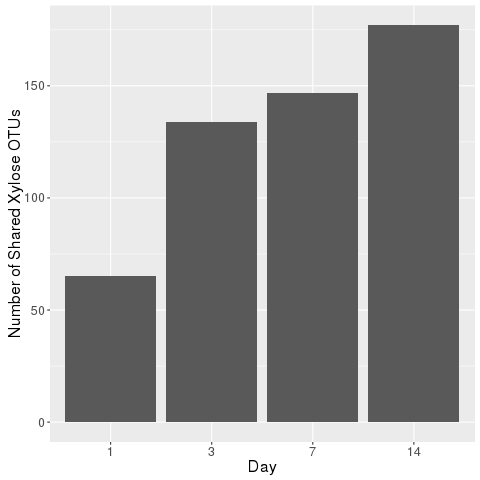

In [22]:
%%R
overlap.xyl = ggplot(xyl.comm.OTUs, aes(x = Day, y = overlap)) + geom_bar(stat= 'identity') + 
        ylab('Number of Shared Xylose OTUs') + theme(text = element_text(size=16))
overlap.xyl

In [23]:
%%R
N.C.D3 = filter(df.l2fc.f, ls == '13C-NTH', padj <=0.10, Day == 3)
P.C.D3 = filter(df.l2fc.f, ls == '13C-PTH', padj <=0.10, Day == 3)

N.C.D7 = filter(df.l2fc.f, ls == '13C-NTH', padj <=0.10, Day == 7)
P.C.D7 = filter(df.l2fc.f, ls == '13C-PTH', padj <=0.10, Day == 7)

N.C.D14 = filter(df.l2fc.f, ls == '13C-NTH', padj <=0.10, Day == 14)
P.C.D14 = filter(df.l2fc.f, ls == '13C-PTH', padj <=0.10, Day == 14)

N.C.D30 = filter(df.l2fc.f, ls == '13C-NTH', padj <=0.10, Day == 30)
P.C.D30 = filter(df.l2fc.f, ls == '13C-PTH', padj <=0.10, Day == 30)

In [24]:
%%R
print(length(intersect(N.C.D3$OTU, P.C.D3$OTU)))
print(length(intersect(N.C.D7$OTU, P.C.D7$OTU)))
print(length(intersect(N.C.D14$OTU, P.C.D14$OTU)))
print(length(intersect(N.C.D30$OTU, P.C.D30$OTU)))

[1] 13
[1] 64
[1] 243
[1] 216


In [25]:
%%R
overlap = c(13, 64, 243, 216)
Day = as.factor(c(3,7,14,30))
cell.comm.OTUs = data.frame(overlap, Day)

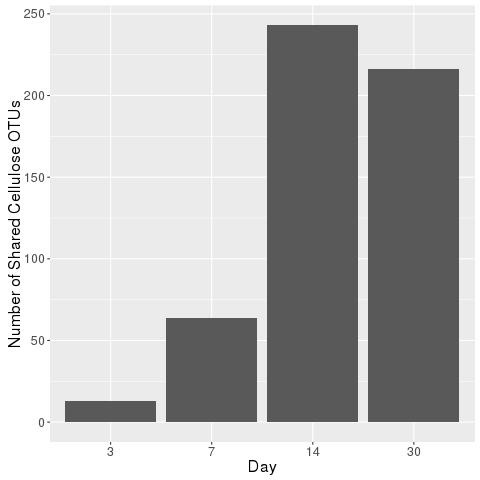

In [26]:
%%R
overlap.cell = ggplot(cell.comm.OTUs, aes(x = Day, y = overlap)) + geom_bar(stat= 'identity') + 
        ylab('Number of Shared Cellulose OTUs') + theme(text = element_text(size=16))
overlap.cell

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘cowplot’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:ggplot2’:

    ggsave


  res = super(Function, self).__call__(*new_args, **new_kwargs)


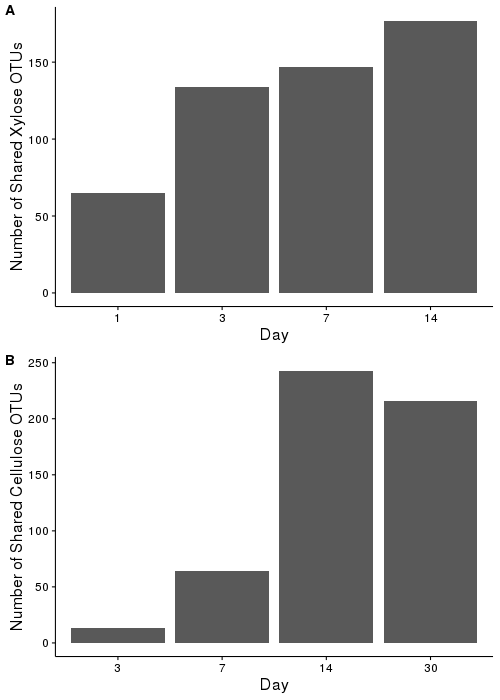

In [27]:
%%R -w 500 -h 700
library(cowplot)


plot_grid(overlap.xyl, overlap.cell, nrow = 2, align = 'v', rel_heights = c(5, 5), labels = c("A", "B"))


### Number of incorporators per treatment

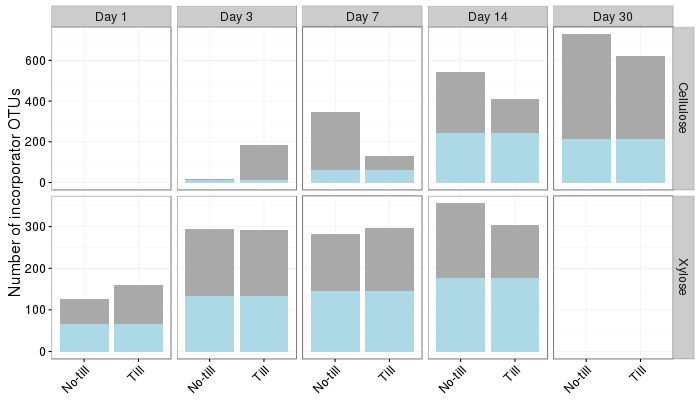

In [28]:
%%R -h 400 -w 700


df.l2fc.f.Sig = df.l2fc.f %>%
    group_by(Treatment, Day,Land_Management) %>%
    summarize(n_taxa = length(unique(OTU)),
              n_incorp = sum(padj < padj_cutoff),
              n_incorp_perc = n_incorp / n_taxa * 100)
              

df.l2fc.f.Sig$Treatment = reorder(df.l2fc.f.Sig$Treatment, -df.l2fc.f.Sig$n_incorp_perc)
df.l2fc.f.Sig$shared = c(13,13,64,64,243,243,216,216,65,65,134,134,145,146,177,177)
df.l2fc.f.Sig$unique = df.l2fc.f.Sig$n_incorp - df.l2fc.f.Sig$shared 



names = c('13X' = "Xylose",
          '13C' = "Cellulose",
          '1' = "Day 1",
          '3' = "Day 3",
          '7' = "Day 7",
          '14' = "Day 14",
          '30' = "Day 30"
                    )

p.nIncSub = ggplot(df.l2fc.f.Sig) +
    geom_bar(aes(x = Land_Management, y = n_incorp), stat='identity', fill = ' dark grey') + 
    geom_bar(aes(Land_Management, shared), stat='identity', fill = 'light blue') +
    labs(y='Number of incorporator OTUs') + facet_grid(Treatment~Day, labeller = as_labeller(names), scales = 'free_y')+
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
        axis.title.x = element_blank()
        ) + scale_x_discrete(labels=c("No-till", "Till"))
p.nIncSub

## Beta Diversity between till and no-till incorporator communities

In [29]:
%%R
df.sig = filter(df.l2fc.f, padj <=0.10)

NC.D3 = filter(df.sig, Land_Management == 'NTH', Substrate == '13C',Day == 3)
NC.D7 = filter(df.sig, Land_Management == 'NTH', Substrate == '13C',Day == 7)
NC.D14 = filter(df.sig, Land_Management == 'NTH',Substrate == '13C', Day == 14)
NC.D30 = filter(df.sig, Land_Management == 'NTH',Substrate == '13C', Day == 30)

PC.D3 = filter(df.sig, Land_Management == 'PTH',Substrate == '13C', Day == 3)
PC.D7 = filter(df.sig, Land_Management == 'PTH', Substrate == '13C',Day == 7)
PC.D14 = filter(df.sig, Land_Management == 'PTH', Substrate == '13C',Day == 14)
PC.D30 = filter(df.sig, Land_Management == 'PTH',Substrate == '13C', Day == 30)

NX.D3 = filter(df.sig, Land_Management == 'NTH', Substrate == '13X', Day == 1)
NX.D7 = filter(df.sig, Land_Management == 'NTH',Substrate == '13X', Day == 3)
NX.D14 = filter(df.sig, Land_Management == 'NTH',Substrate == '13X', Day == 7)
NX.D30 = filter(df.sig, Land_Management == 'NTH',Substrate == '13X', Day == 14)

PX.D3 = filter(df.sig, Land_Management == 'PTH', Substrate == '13X', Day == 1)
PX.D7 = filter(df.sig, Land_Management == 'PTH', Substrate == '13X', Day == 3)
PX.D14 = filter(df.sig, Land_Management == 'PTH', Substrate == '13X', Day == 7)
PX.D30 = filter(df.sig, Land_Management == 'PTH', Substrate == '13X', Day == 14)

In [30]:
%%R

sdm = physeq %>% sample_data %>% 
    filter(! is.na(Density),
           Treatment != '12C') %>%
    select(Treatment, Day) %>%
    distinct() %>%
    arrange(Treatment, Day) 

sdm %>% nrow %>% print
sdm %>% head(n=5)

[1] 8
  Treatment Day
1       13C   3
2       13C   7
3       13C  14
4       13C  30
5       13X   1


In [31]:
%%R
     
asNumeric = function(x) {as.numeric(as.character(x)) }

get_Adonis = function(physeq.obj,df.LFC, Treatment, Day){
        
    # filtering L2FC df
    df.sig.NTH = filter(df.LFC, Land_Management == 'NTH',Substrate == Treatment, Day == Day)
    df.sig.PTH = filter(df.LFC, Land_Management == 'NTH',Substrate == Treatment, Day == Day)
    
    Treatment = c(Treatment %>% as.character)
    physeq.md = sample_data(physeq.obj)
    
    
    
    # filtering
    p.NTH = prune_samples((! is.na(physeq.md$Density)) &
                          (physeq.md$Land_Management == "NTH") &
                          (physeq.md$Day == Day) &
                          (physeq.md$Treatment == Treatment),
                           physeq.obj) 
    p.NTH = prune_taxa(as.character(df.sig.NTH$OTU),
                           p.NTH) 
    
    p.PTH = prune_samples((! is.na(physeq.md$Density)) & 
                      (physeq.md$Land_Management == "PTH") &
                      (physeq.md$Day == Day) &
                      (physeq.md$Treatment == Treatment),
                      physeq.obj)
    p.PTH = prune_taxa(as.character(df.sig.NTH$OTU),
                           p.PTH) 
    
    physeq.m = merge_phyloseq(p.NTH, p.PTH) 
    physeq.m = filter_taxa(physeq.m, function(x) sum(x > 0) > 0.25 * length(x), TRUE)   
    
    # applying 'heavy' window pruning
    physeq.md = sample_data(physeq.m)

    physeq.m = prune_samples((physeq.md$Density >= 1.70) &
                             (physeq.md$Density <= 1.77),  physeq.m)
    
    ## Calculating weighted Unifrac
    wunif.dist = distance(physeq.m,
                          method = "unifrac", 
                          weighted = TRUE,
                          fast = TRUE, 
                          parallel = TRUE, 
                          normalized = FALSE)
        
    ## Calculating ADONIS
    
    physeq.data = as(sample_data(physeq.m), "data.frame")
    ad = adonis(wunif.dist ~ Till, physeq.data)
    
    d = data.frame(ad$aov.tab)
    d$Day = Day
    d$Treatment = Treatment
    return(d)

    
}
                                                         

In [32]:
%%R
Adonis = mdply(sdm,
                get_Adonis, 
                physeq.obj = physeq,
                df.LFC = df.l2fc.f) %>% tbl_df

In [33]:
%%R
Adonis.2 = filter(Adonis, !(is.na(F.Model)))
Adonis.2

Source: local data frame [8 x 8]

     Df  SumsOfSqs    MeanSqs   F.Model         R2 Pr..F.   Day Treatment
  (dbl)      (dbl)      (dbl)     (dbl)      (dbl)  (dbl) (int)     (chr)
1     1 0.15192384 0.15192384  9.397687 0.23853399  0.001     3       13C
2     1 0.08561994 0.08561994  3.456498 0.10988185  0.022     7       13C
3     1 0.09303891 0.09303891  2.334450 0.07003114  0.085    14       13C
4     1 0.12904486 0.12904486  4.578463 0.13240794  0.003    30       13C
5     1 0.44477069 0.44477069 16.347264 0.35271260  0.001     1       13X
6     1 0.16304914 0.16304914  8.747725 0.22576100  0.001     3       13X
7     1 0.22592390 0.22592390 10.309275 0.26226062  0.001     7       13X
8     1 0.06066489 0.06066489  2.681239 0.08463175  0.042    14       13X


In [34]:
%%R
df.sig.ann = left_join(df.l2fc.f.Sig, Adonis.2, by = c('Treatment', 'Day'))

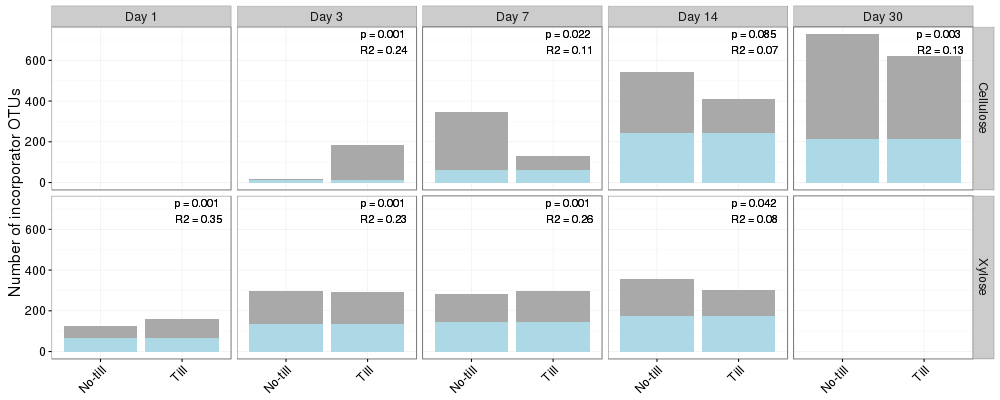

In [65]:
%%R -h 400 -w 1000


df.l2fc.f.Sig = df.l2fc.f %>%
    group_by(Treatment, Day,Land_Management) %>%
    summarize(n_taxa = length(unique(OTU)),
              n_incorp = sum(padj < padj_cutoff),
              n_incorp_perc = n_incorp / n_taxa * 100)
              

df.l2fc.f.Sig$Treatment = reorder(df.l2fc.f.Sig$Treatment, -df.l2fc.f.Sig$n_incorp_perc)
df.l2fc.f.Sig$shared = c(13,13,64,64,243,243,216,216,65,65,134,134,145,146,177,177)
df.l2fc.f.Sig$unique = df.l2fc.f.Sig$n_incorp - df.l2fc.f.Sig$shared 

df.sig.ann = left_join(df.l2fc.f.Sig, Adonis.2, by = c('Treatment', 'Day'))

df.sig.ann$labels = paste('p =', df.sig.ann$`Pr..F.`,'\nR2 =', round(df.sig.ann$R2, digits = 2))
names = c('13X' = "Xylose",
          '13C' = "Cellulose",
          '1' = "Day 1",
          '3' = "Day 3",
          '7' = "Day 7",
          '14' = "Day 14",
          '30' = "Day 30"
                    )

p.nIncSub = ggplot(df.sig.ann) +
    geom_bar(aes(x = Land_Management, y = n_incorp), stat='identity', fill = ' dark grey') + 
    geom_bar(aes(Land_Management, shared), stat='identity', fill = 'light blue') +
    labs(y='Number of incorporator OTUs') + facet_grid(Treatment~Day, labeller = as_labeller(names))+
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
        axis.title.x = element_blank()
        ) + scale_x_discrete(labels=c("No-till", "Till")) +
    geom_text(x = 2.2, y = 690, aes(n_incorp, label = labels))


p.nIncSub

In [66]:
%%R
ggsave('data/figs/ninc_shared_R2.png', width = 12, height = 6)

In [36]:
%%R
df.sigin = filter(df.filt, padj <=0.10)%>% complete(Land_Management)%>%group_by(Group,Day, Treatment, Land_Management)  %>%
            summarise(inc = n()) %>% spread(Land_Management, inc, fill = 0) %>% 
            filter(Group %in% c('__Actinobacteria', '__Bacteroidetes', '__Candidate_division_WS3', '__Chloroflexi',
                               '__Firmicutes', '__Gemmatimonadetes', '__Planctomycetes', '__Verrucomicrobia', 
                               '__Alphaproteobacteria', '__Betaproteobacteria', '__Deltaproteobacteria', 
                                "__Gammaproteobacteria"), Treatment == '13C')
                                                                                              

(df.sigin) %>% as.data.frame


Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'df.filt' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'df.filt' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning messages:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: replacing previous import ‘BiocGenerics::Position’ by ‘ggplot2::Position’ when loading ‘phyloseq’ 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/

In [37]:
%%R
unique(df.filt$Rank2)


Error in unique(df.filt$Rank2) : object 'df.filt' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in unique(df.filt$Rank2) : object 'df.filt' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


## Fischer's Exact test for each phylum

In [38]:
%%R
df.Prots = filter(df.l2fc.f, Rank2 == '__Proteobacteria')
df.Prots$Group = df.Prots$Rank3
df.nonProts = filter(df.l2fc.f, Rank2 != '__Proteobacteria')
df.nonProts$Group = df.nonProts$Rank2

df.filt = rbind(df.Prots, df.nonProts)



In [39]:
%%R
df.sigin = filter(df.filt, padj <=0.10)%>% complete(Land_Management)%>%group_by(Rank2, Treatment, Land_Management)  %>%
            summarise(inc = n()) %>% spread(Land_Management, inc, fill = 0)

head(df.sigin)

Source: local data frame [6 x 4]
Groups: Rank2, Treatment [6]

              Rank2 Treatment   NTH   PTH
             (fctr)    (fctr) (dbl) (dbl)
1   __Acidobacteria       13C    45    44
2   __Acidobacteria       13X     3     4
3  __Actinobacteria       13C    99   142
4  __Actinobacteria       13X   263   265
5 __Armatimonadetes       13C    18    28
6 __Armatimonadetes       13X     0     1


In [40]:
%%R
Fishers.phylum = function(Group, Treatment, sig) {
    sig = sig %>% as.data.frame

    df.t = sig[sig$Group == Group & sig$Treatment == Treatment,]
    inc = data.frame(as.numeric(df.t$NTH), as.numeric(df.t$PTH))
    inc = inc[complete.cases(inc),] #removing rows of na
    
    noninc = sum(inc) - inc
    test2 = rbind(inc, noninc)
    
    colnames(test2) = c('N', 'P')
    rownames(test2) = c('responders', 'non-responders')
        
    ftest = fisher.test(test2)
    
     d = data.frame(ftest$p.value)
    d$Phyla = Group
    return(d)
    
}

In [41]:
%%R
df.sig.xyl = df.sigin %>% ungroup %>% filter(Treatment == '13X', !(is.na(Group)))

sdm.xyl = df.sig.xyl %>% 
    select(Group, Treatment) %>%
    distinct() %>%
    arrange(Group, Treatment) 

sdm.xyl = tbl_df(sdm.xyl)


Error in eval(expr, envir, enclos) : object 'Group' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in eval(expr, envir, enclos) : object 'Group' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [42]:
%%R
df.l2fc.xylphyl = mdply(sdm.xyl ,
                Fishers.phylum, 
                 sig = df.sig.xyl) %>% tbl_df


Error in mdply(sdm.xyl, Fishers.phylum, sig = df.sig.xyl) : 
  object 'sdm.xyl' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in mdply(sdm.xyl, Fishers.phylum, sig = df.sig.xyl) : 
  object 'sdm.xyl' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [43]:
%%R
df.l2fc.xylphyl$padj = p.adjust(df.l2fc.xylphyl$ftest.p.value, method = 'bonferroni')
head(df.l2fc.xylphyl)


Error in p.adjust(df.l2fc.xylphyl$ftest.p.value, method = "bonferroni") : 
  object 'df.l2fc.xylphyl' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in p.adjust(df.l2fc.xylphyl$ftest.p.value, method = "bonferroni") : 
  object 'df.l2fc.xylphyl' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [44]:
%%R
df.l2fc.xylphyl$roundp = round(df.l2fc.xylphyl$padj, digits = 3)


Error in withVisible({ : object 'df.l2fc.xylphyl' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in withVisible({ : object 'df.l2fc.xylphyl' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [45]:
%%R
test = filter(df.l2fc.xylphyl, padj <0.05)  %>% as.data.frame
test


Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'df.l2fc.xylphyl' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'df.l2fc.xylphyl' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [46]:
%%R
test2 = filter(df.l2fc.xylphyl, !(Group %in% test$Group))
unique(test2$Group)


Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'df.l2fc.xylphyl' not found


In [47]:
%%R
#For cellulose
df.sig.cell = df.sigin %>% ungroup %>% filter(Treatment == '13C', !(is.na(Group)))

sdm.cell = df.sig.cell %>% 
    select(Group, Treatment) %>%
    distinct() %>%
    arrange(Group, Treatment) 

sdm.cell = tbl_df(sdm.cell)


Error in eval(expr, envir, enclos) : object 'Group' not found


In [48]:
%%R
df.l2fc.cellphyl = mdply(sdm.cell ,
                Fishers.phylum, 
                 sig = df.sig.cell) %>% tbl_df


Error in mdply(sdm.cell, Fishers.phylum, sig = df.sig.cell) : 
  object 'sdm.cell' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in mdply(sdm.cell, Fishers.phylum, sig = df.sig.cell) : 
  object 'sdm.cell' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [49]:
%%R

    df.t = df.sig.cell[df.sig.cell$Group == '__Deltaproteobacteria' & df.sig.cell$Treatment == '13C',]
    inc = data.frame(as.numeric(df.t$NTH), as.numeric(df.t$PTH))
    inc = inc[complete.cases(inc),] #removing rows of na
    
    noninc = sum(inc) - inc
    test2 = rbind(inc, noninc)
    
    test2
inc
    


Error in withVisible({ : object 'df.sig.cell' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in withVisible({ : object 'df.sig.cell' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [50]:
%%R
df.l2fc.cellphyl$padj = p.adjust(df.l2fc.cellphyl$ftest.p.value, method = 'bonferroni')
head(df.l2fc.cellphyl)


Error in p.adjust(df.l2fc.cellphyl$ftest.p.value, method = "bonferroni") : 
  object 'df.l2fc.cellphyl' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in p.adjust(df.l2fc.cellphyl$ftest.p.value, method = "bonferroni") : 
  object 'df.l2fc.cellphyl' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [51]:
%%R
test= filter(df.l2fc.cellphyl, padj <0.05) %>% as.data.frame
test$pround = round(test$padj, digits = 3)
test


Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'df.l2fc.cellphyl' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'df.l2fc.cellphyl' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [52]:
%%R
test2 = filter(df.l2fc.cellphyl, !(Group %in% test$Group))
unique(test2$Group)


Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'df.l2fc.cellphyl' not found


## Fischer's Exact test for each phylum, day combination

In [53]:
%%R
df.sigin = filter(df.filt, padj <=0.10)%>% complete(Land_Management)%>%group_by(Group, Day, Treatment, Land_Management)  %>%
            summarise(inc = n()) %>% spread(Land_Management, inc, fill = 0)

head(df.sigin)

Source: local data frame [6 x 5]
Groups: Group, Day, Treatment [6]

                  Group   Day Treatment   NTH   PTH
                 (fctr) (int)    (fctr) (dbl) (dbl)
1 __Alphaproteobacteria     1       13X    33    35
2 __Alphaproteobacteria     3       13C     3    17
3 __Alphaproteobacteria     3       13X    66    49
4 __Alphaproteobacteria     7       13C    61    28
5 __Alphaproteobacteria     7       13X    58    51
6 __Alphaproteobacteria    14       13C    79    70


In [54]:
%%R
Fishers.xylose = function(Group, Day, Treatment, sig) {
    sig = sig %>% as.data.frame

    df.t = sig[sig$Group == Group & sig$Day == Day & sig$Treatment == Treatment,]
    inc = data.frame(as.numeric(df.t$NTH), as.numeric(df.t$PTH))
    inc = inc[complete.cases(inc),] #removing rows of na
    
    noninc = sum(inc) - inc
    test2 = rbind(inc, noninc)
    
    colnames(test2) = c('N', 'P')
    rownames(test2) = c('responders', 'non-responders')
        
    ftest = fisher.test(test2)
    
     d = data.frame(ftest$p.value)
    d$Day = Day
    d$Phyla = Group
    return(d)
    
}

In [55]:
%%R
df.sig.xyl = df.sigin %>% ungroup %>% filter(Treatment == '13X', !(is.na(Group)))

sdm.xyl = df.sig.xyl %>% 
    select(Group, Day, Treatment) %>%
    distinct() %>%
    arrange(Group, Day, Treatment) 

sdm.xyl = tbl_df(sdm.xyl)

In [56]:
%%R
df.l2fc = mdply(sdm.xyl ,
                Fishers.xylose, 
                 sig = df.sig.xyl) %>% tbl_df

In [57]:
%%R
df.l2fc$padj = p.adjust(df.l2fc$ftest.p.value, method = 'bonferroni')
head(df.l2fc)

Source: local data frame [6 x 6]

                  Group Treatment ftest.p.value   Day                 Phyla
                 (fctr)    (fctr)         (dbl) (int)                (fctr)
1 __Alphaproteobacteria       13X  0.8639164267     1 __Alphaproteobacteria
2 __Alphaproteobacteria       13X  0.0346305651     3 __Alphaproteobacteria
3 __Alphaproteobacteria       13X  0.4164322225     7 __Alphaproteobacteria
4 __Alphaproteobacteria       13X  0.0441254116    14 __Alphaproteobacteria
5  __Betaproteobacteria       13X  0.0800865801     1  __Betaproteobacteria
6  __Betaproteobacteria       13X  0.0005867726     3  __Betaproteobacteria
Variables not shown: padj (dbl)


In [58]:
%%R
df.l2fc$roundp = round(df.l2fc$padj, digits = 3)
test = filter(df.l2fc, padj <0.05) %>% as.data.frame
test

                      Group Treatment ftest.p.value Day
1      __Betaproteobacteria       13X  5.867726e-04   3
2      __Betaproteobacteria       13X  1.327366e-07  14
3     __Deltaproteobacteria       13X  5.435083e-04   7
4     __Gammaproteobacteria       13X  2.285725e-04   3
5     __Gammaproteobacteria       13X  5.916714e-12  14
6           __Bacteroidetes       13X  2.187190e-04   1
7           __Bacteroidetes       13X  2.442463e-04   7
8  __Candidate_division_WS3       13X  1.082509e-05   1
9             __Chloroflexi       13X  7.640709e-05  14
10             __Firmicutes       13X  1.421636e-08   3
11         __Planctomycetes       13X  2.048365e-08   3
12         __Planctomycetes       13X  6.052522e-05   7
                      Phyla         padj roundp
1      __Betaproteobacteria 3.755345e-02  0.038
2      __Betaproteobacteria 8.495143e-06  0.000
3     __Deltaproteobacteria 3.478453e-02  0.035
4     __Gammaproteobacteria 1.462864e-02  0.015
5     __Gammaproteobacteria 3.78

In [59]:
%%R
test2 = filter(df.l2fc, !(Group %in% test$Group))
unique(test2$Group)

 [1] __Alphaproteobacteria     __TA18                   
 [3] __Acidobacteria           __Actinobacteria         
 [5] __Armatimonadetes         __Candidate_division_BRC1
 [7] __Candidate_division_TM7  __Cyanobacteria          
 [9] __Fibrobacteres           __Gemmatimonadetes       
[11] __Lentisphaerae           __Spirochaetes           
[13] __TA06                    __Verrucomicrobia        
[15] __WCHB1-60               
15 Levels: __Alphaproteobacteria __TA18 __Acidobacteria ... __WCHB1-60


In [60]:
%%R
df.sig.cell = df.sigin %>% ungroup %>% filter(Treatment == '13C', !(is.na(Group)))

sdm.cell = df.sig.cell %>% 
    select(Group, Day, Treatment) %>%
    distinct() %>%
    arrange(Group, Day, Treatment) 

sdm.cell = tbl_df(sdm.cell)

In [61]:
%%R
df.l2fc.cell = mdply(sdm.cell ,
                Fishers.xylose, 
                 sig = df.sig.cell) %>% tbl_df

In [62]:
%%R
df.l2fc.cell$padj = p.adjust(df.l2fc.cell$ftest.p.value, method = 'bonferroni')
head(df.l2fc.cell)

Source: local data frame [6 x 6]

                  Group Treatment ftest.p.value   Day                 Phyla
                 (fctr)    (fctr)         (dbl) (int)                (fctr)
1 __Alphaproteobacteria       13C  1.938534e-05     3 __Alphaproteobacteria
2 __Alphaproteobacteria       13C  1.241957e-06     7 __Alphaproteobacteria
3 __Alphaproteobacteria       13C  3.540241e-01    14 __Alphaproteobacteria
4 __Alphaproteobacteria       13C  6.463600e-02    30 __Alphaproteobacteria
5  __Betaproteobacteria       13C  3.430672e-01     3  __Betaproteobacteria
6  __Betaproteobacteria       13C  8.322527e-08     7  __Betaproteobacteria
Variables not shown: padj (dbl)


In [63]:
%%R
test = filter(df.l2fc.cell, padj <0.05) %>% as.data.frame
test$pround = round(test$padj, digits = 3)
test

                      Group Treatment ftest.p.value Day
1     __Alphaproteobacteria       13C  1.938534e-05   3
2     __Alphaproteobacteria       13C  1.241957e-06   7
3      __Betaproteobacteria       13C  8.322527e-08   7
4     __Deltaproteobacteria       13C  1.082509e-05   3
5     __Deltaproteobacteria       13C  7.195738e-06  14
6     __Gammaproteobacteria       13C  7.261638e-06   3
7     __Gammaproteobacteria       13C  1.925779e-10  30
8          __Actinobacteria       13C  1.606288e-29   3
9          __Actinobacteria       13C  3.472829e-04   7
10          __Bacteroidetes       13C  7.396023e-07   3
11          __Bacteroidetes       13C  7.746627e-15   7
12 __Candidate_division_WS3       13C  3.715691e-12   3
13 __Candidate_division_WS3       13C  3.327342e-09  30
14            __Chloroflexi       13C  3.715691e-12   3
15             __Firmicutes       13C  5.230556e-06  30
16       __Gemmatimonadetes       13C  3.458873e-04  30
17         __Planctomycetes       13C  4.063370e